In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
import csv

In [29]:
path="/home/yasmine/Téléchargements/data_img/img20.jpg"
image=cv2.imread(path)
with open('/home/yasmine/Téléchargements/file.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        #print(row)
        if row[0]=="montant_en_lettres":
            img_cropped = image[int(row[2]):int(row[4]), int(row[1]):int(row[3])]
            cv2.imwrite('montant_en_lettres.jpg',img_cropped)
        elif row[0]=="montant_en_chiffres":
            img_cropped = image[int(row[2]):int(row[4]), int(row[1]):int(row[3])]
            cv2.imwrite('montant_en_chiffres.jpg',img_cropped)

            

In [2]:
def preprocessing(path):
    image = cv2.imread(path)
    im_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    h,w=im_gray.shape
    #cv2.imwrite('img.jpg',result)
    #image=cv2.imread('img.jpg')
    #gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.GaussianBlur(im_gray, (5,5), 1)
    #plt.imshow(image)
    th =  cv2.adaptiveThreshold(im_gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,3,2)
    #plt.imshow(th)
    #cv2.imwrite('img.jpg',th)
    #image=cv2.imread('img.jpg')
    #gray = cv2.cvtColor(th, cv2.COLOR_BGR2GRAY)
    #plt.imshow(gray)
    contours, hierarchy = cv2.findContours(th, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    #cv2.drawContours(img, contours, -1, (0,255,0), 2)
    # create an empty mask
    mask = np.zeros(image.shape[:2], dtype=np.uint8)

    # loop through the contours
    for i, cnt in enumerate(contours):
        # if the contour has no other contours inside of it
        if hierarchy[0][i][2] == -1:
            # if the size of the contour is greater than a threshold
            if cv2.contourArea(cnt) <70:
                cv2.drawContours(mask, [cnt], 0, (255), -1)
    #plt.imshow(mask)
    result=th+mask
    #plt.imshow(result)
    result = cv2.GaussianBlur(result, (3,3), 0)
    #plt.imshow(result)
    thresh = cv2.threshold(im_gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 1))
    detected_lines = cv2.morphologyEx(thresh, cv2.MORPH_OPEN,
    horizontal_kernel, iterations=2)

    cnts = cv2.findContours(detected_lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    for c in cnts:
        cv2.drawContours(result, [c], -1, (255, 255, 255), 2)
    #plt.imshow(result)
    repair_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 6))
    result =255 -  cv2.morphologyEx(255 - result, cv2.MORPH_CLOSE, repair_kernel,
                                iterations=1)


    
    return result

In [3]:
def projection(result):
    #gray = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
    _, binarizedImage = cv2.threshold(result, 127, 255, cv2.THRESH_BINARY)
    binarizedImage[binarizedImage == 0] = 1
    binarizedImage[binarizedImage == 255] = 0
    vertical_projection = np.sum(binarizedImage, axis=0)
    for i in range(len(vertical_projection)):
        if vertical_projection[i]<4:
            vertical_projection[i]=0
            
    return vertical_projection 

In [4]:
def segmentation(width,height,inputImage):
    
    start=0
    end=0
    j=0
    for row in range(width):
        #print(row,vertical_projection[row])
        #print(horizontal_projection[row+1])
        if vertical_projection[row-1]==0 and vertical_projection[row]!=0 and veriferavant(row-1)>15:
        
            start=row-2
            #print("s",start)
        #print(veriferarriere(row+1,width))
        if vertical_projection[row-1]!=0 and vertical_projection[row]==0  and veriferarriere(row,width)>15:
            end=row+1
            #print("e",end)
            
            if(end-start>50):
                print("s",start)
                print("e",end)
                roi=inputImage[0:height,start:end]
                #roi=cv2.resize(roi, (400, 340)) 
                cv2.imwrite("words/word"+str(j)+".png",roi)
                start=0
                end=0
                #plt.imshow(roi)
                j=j+1
        if start!=0 and end==0 and row==width-1:
            roi=inputImage[0:height,start:width]
            #roi=cv2.resize(roi, (400, 340)) 
            cv2.imwrite("words/word"+str(j)+".png",roi)
            j=j+1
  
            
            
    

In [5]:
def veriferavant(row):
    #print(row)
    n=0
    i=1
    while vertical_projection[row-i]==0:
        #print(row-i)
        n=n+1
        i=i+1
        if n > 15:
            break
    #print(n)
    return n
def veriferarriere(row,width):
    n=0
    i=1
    
    #r=row+i
    if((row+i) < int(width)-1) :
        
        while vertical_projection[row+i]==0 :
            n=n+1
            #print("n=",n)
            i=i+1
        
            if n > 15 or row+i>int(width)-1:
                print(n)
                break
    return n   

[ 0  0  0  8  4  0  0  4  6  5  0  0  0  0  7  9 16 11  7  8  6  7 10  9
  7  7  6  7  9  9  9  7  6  7  8  7  8 11 15 10  4  6  8 10  5  5 11 11
 11 10  9 11 12 12 11  8  6  5  5  4  4  0  0  0  0  4  8  8 30 37 18  8
 12 11 13 14  8  7  8  5  5  4  4  4  5  6  5  9 13  7  0  0  0  0 12 16
 25 16 16 14 16 15 15  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  9 14  9  7  8  7  5  7 10 11  9  5  6  5  7  7  7  4  0
  0  0  0  0  0  0  0  0  8 13 16 11  8 11  9  9 13 10 10 12 14 25 30 20
 11  9 13 12 11  0  0  4  4  6 12 13  4  0  0  0  0  0  4  0  0  4 10 13
  5  4  5  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 54 54 33 16
 12 11  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 16 29 21 14 13 10  9
  4  0  0  0  7 44 44 17  0  0  4  4  0  4  5  5  7  7  8  4  5  7  5  7
  5  6  7  8  8  9  8 15 17  9  0  0  0  0  0  6 12 13 12 10  9  6  4  0
  6  6  9  6  4  9  4  5  5  6  6  0  0  5  5  5  4

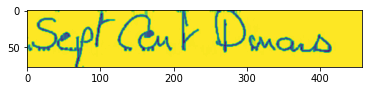

In [6]:
result=preprocessing('montant_en_lettres.jpg')
plt.imshow(result)

vertical_projection =projection(result)
print(vertical_projection)
h,w=result.shape
segmentation(w,h,result)

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  5  6  9  0  0  0  5  7  9  9  9  5  4  4
  4  4  4  4  0 24 39 24 15  9  9 10 12 11 11 11 10 10  8  6  0  0  0  0
 10 12  8  9  7  7  4  4  5  5  4  4  4  5  0  0  0  0  5  4  5  6  5  5
  6 14 11  7  0  0  0  0 12 14 15 11  5  0  4  5  6  6  4  5  5  6  9  6
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  5 10 11  9  6  0  0
  0  0  0  0  0  5  5  5  4  0  4  6  6 12 25 33 32  4  4  5  5  5  4  5
  4  5  4  5  6  6  6  6  6  6 11 12 11 11 20 18  6  0  0  0  0  8 19 13
  9  0  0  0 26 33 33  0  0  0  0  0  0  0  4  5 11 22 16  5  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

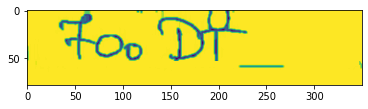

In [10]:
result=preprocessing('montant_en_chiffres.jpg')
plt.imshow(result)

vertical_projection =projection(result)
print(vertical_projection)
h,w=result.shape
segmentation(w,h,result)